<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

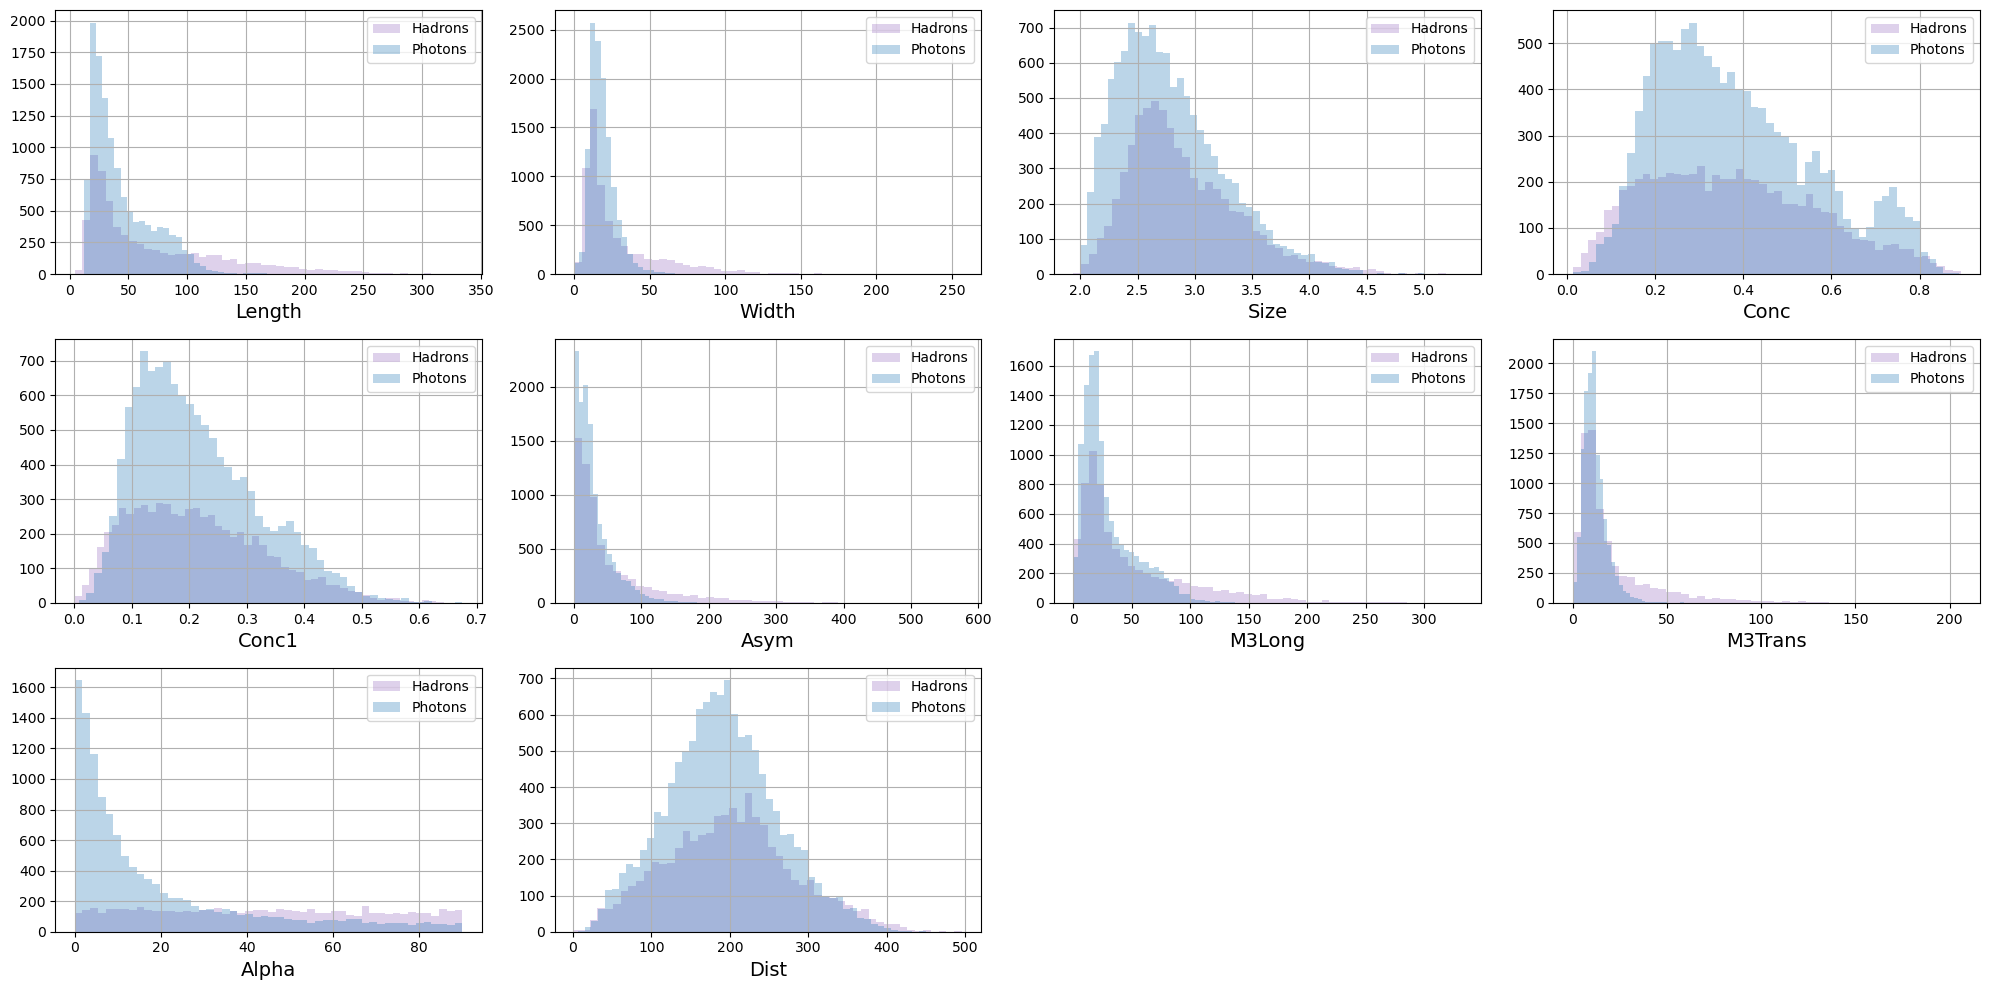

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

In [10]:
(y_train == 1).sum()/y_train.size

0.6483701366982124

In [11]:
(y_test == 1).sum()/y_test.size

0.6483701366982124

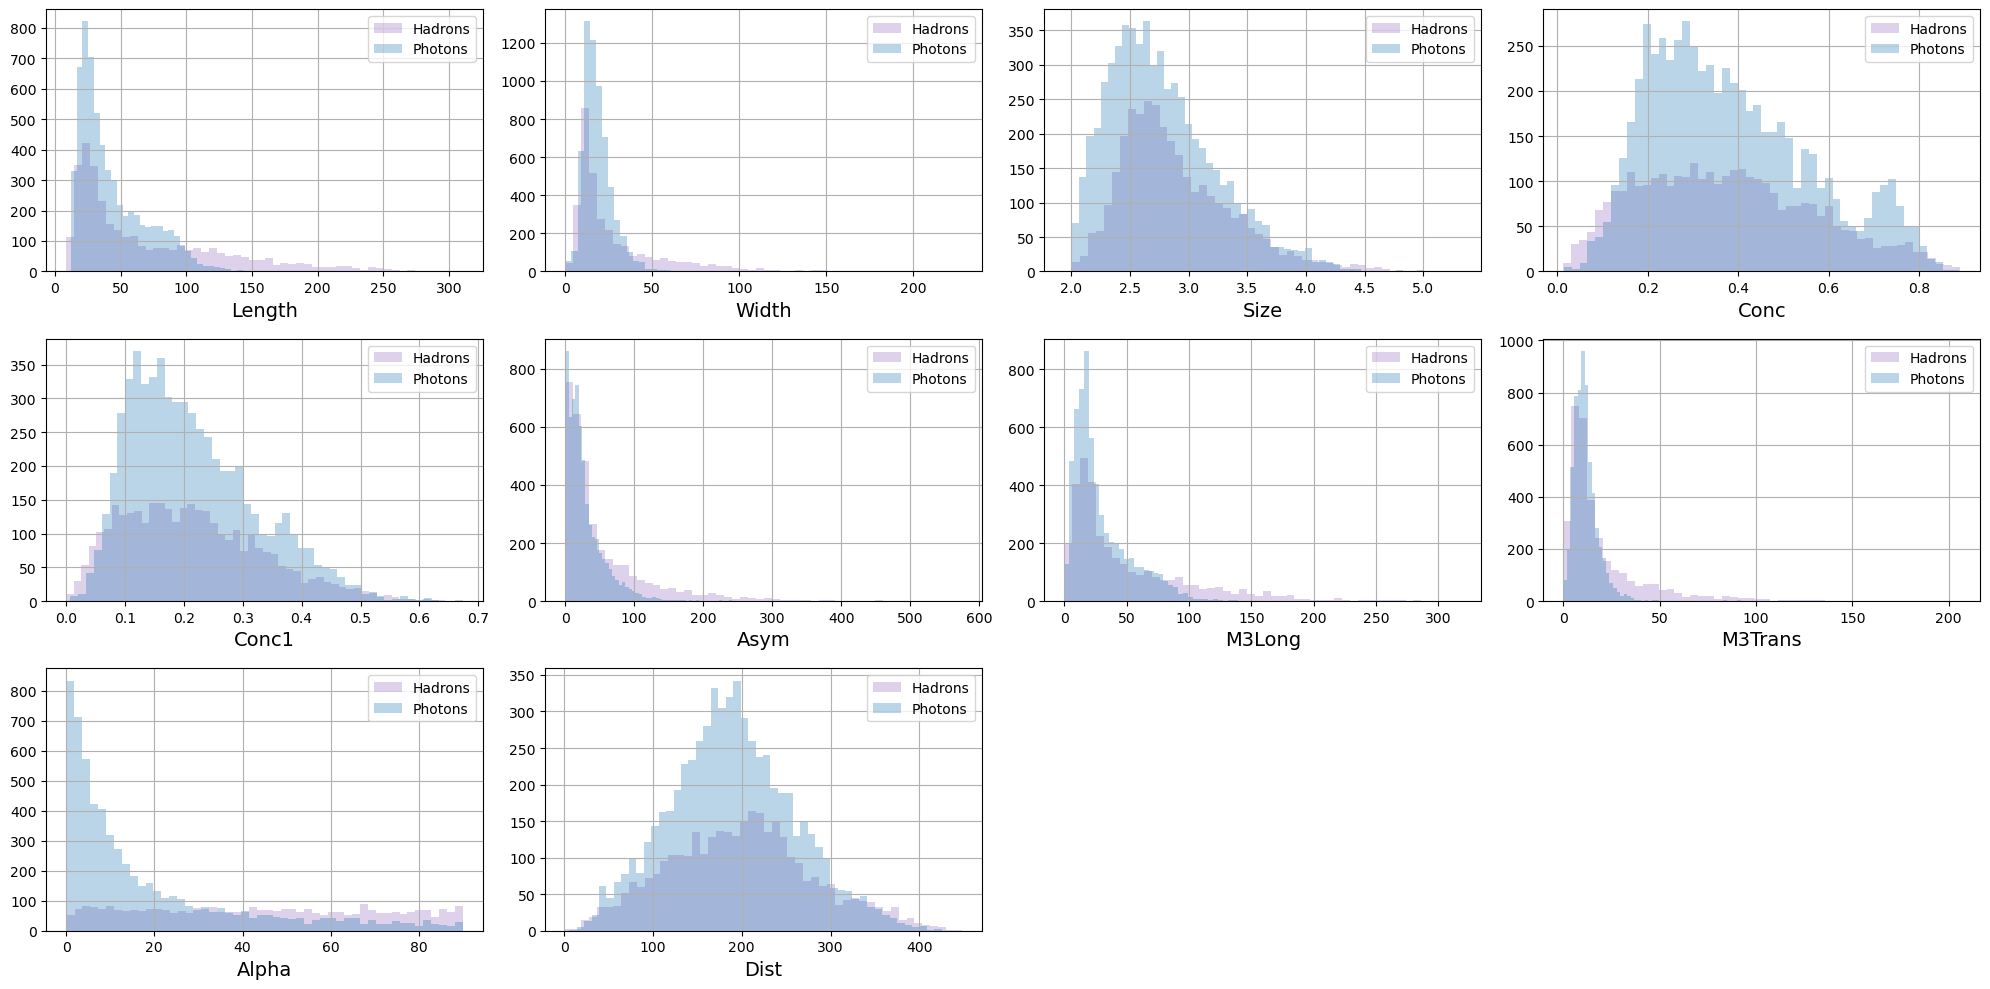

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
from sklearn.preprocessing import QuantileTransformer

In [14]:
qt = QuantileTransformer(output_distribution='normal')

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

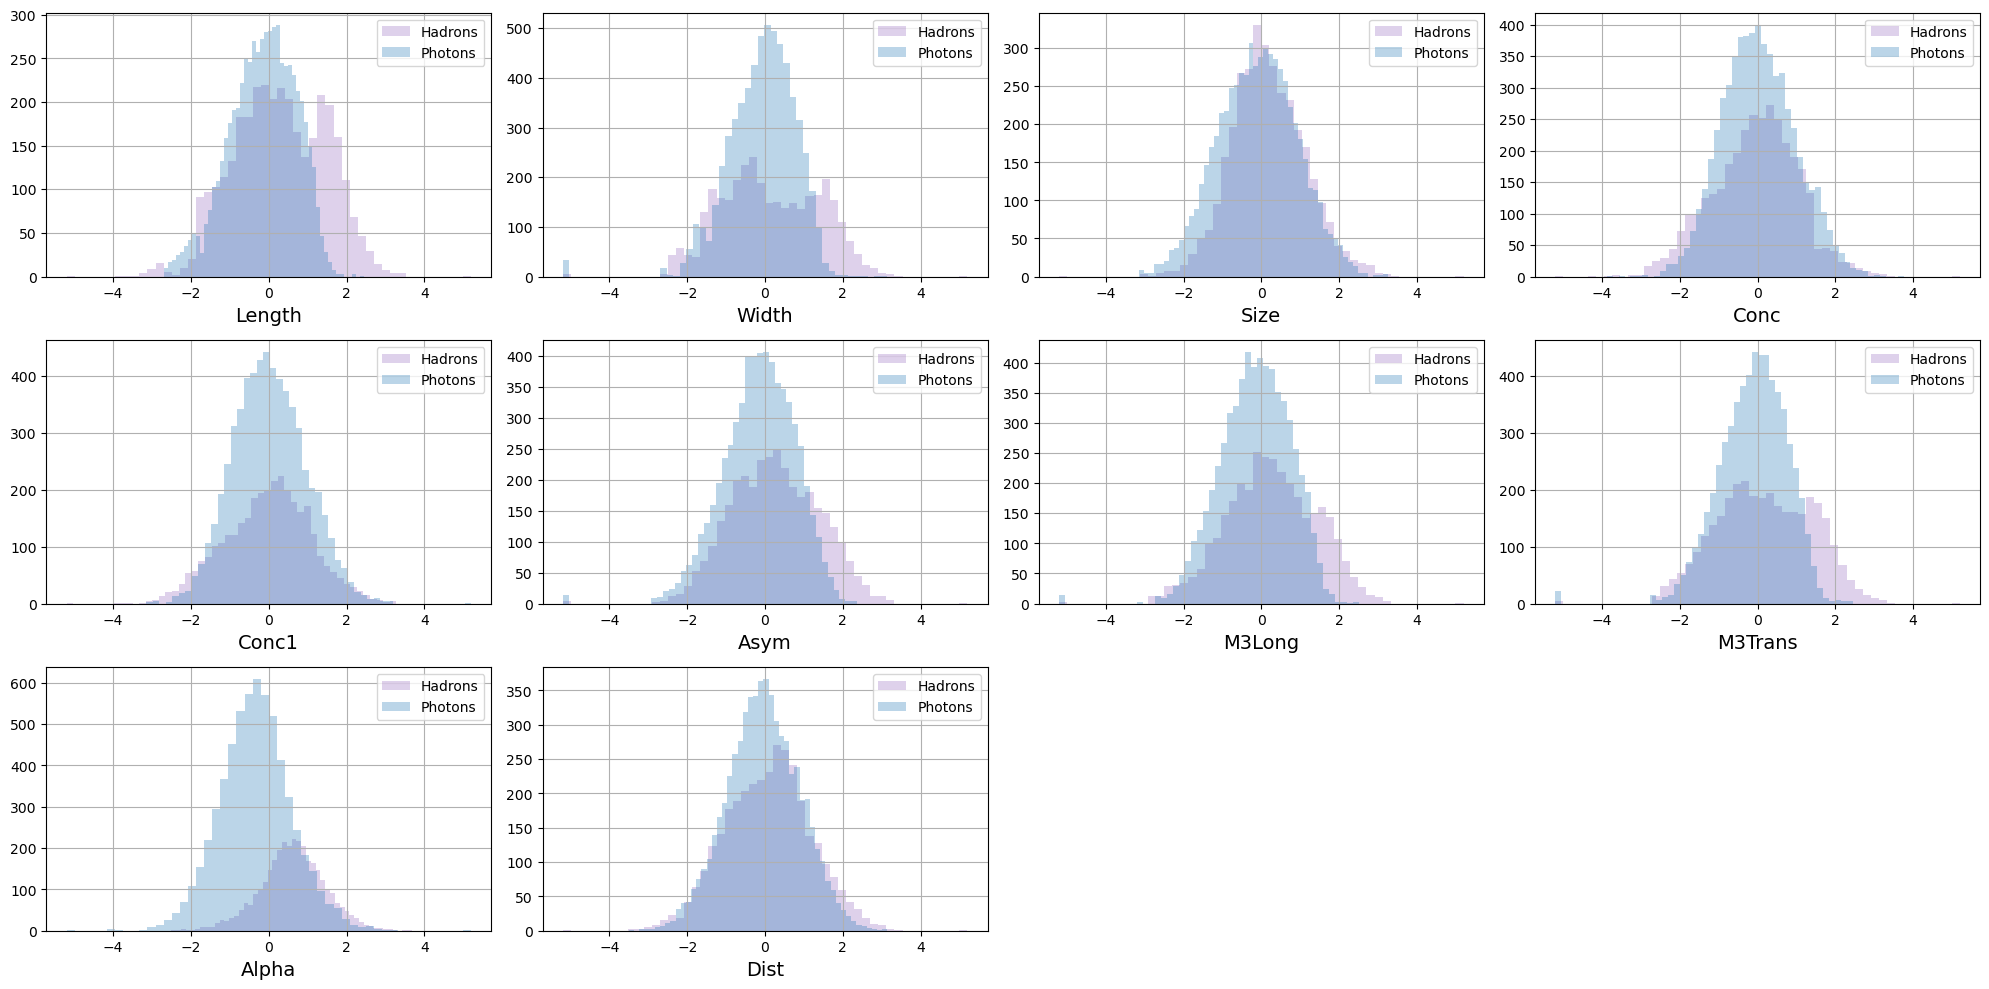

In [15]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

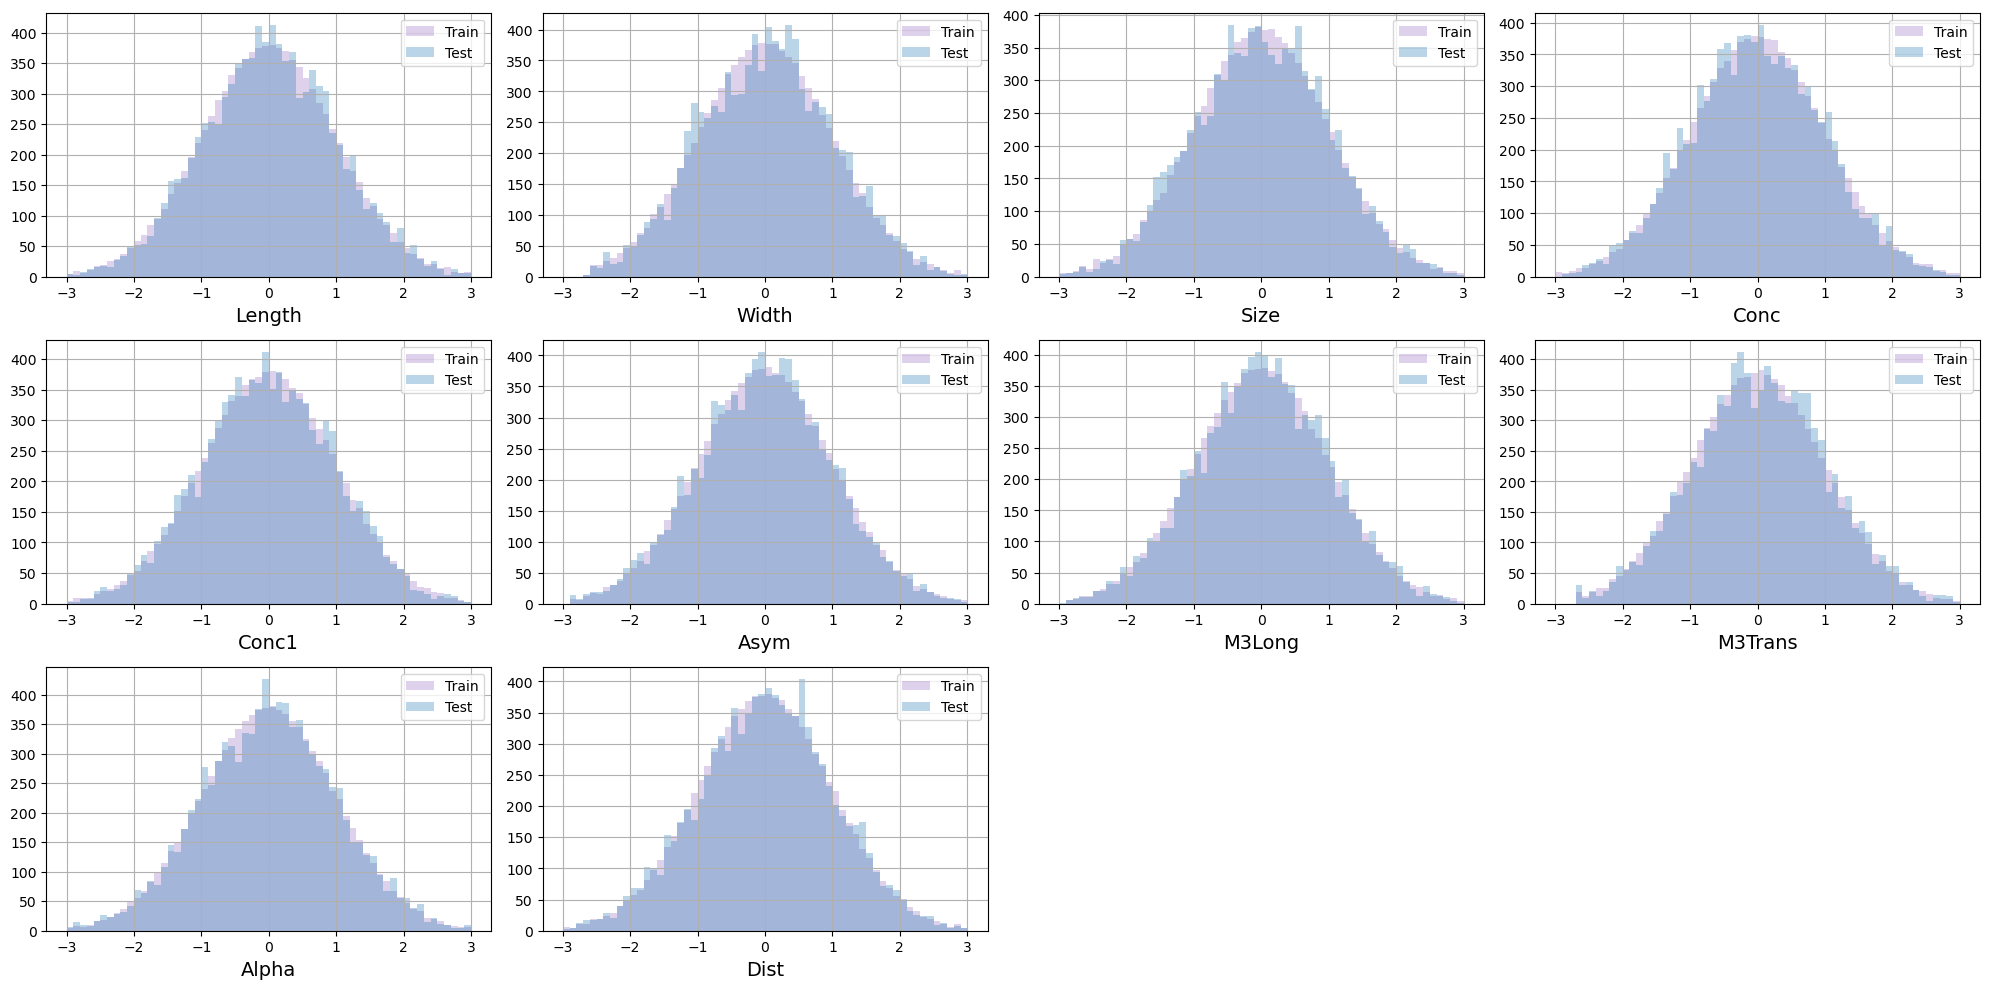

In [16]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [19]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.relu = nn.ReLU()

        self.batch_norm1 = torch.nn.BatchNorm1d(100)
        self.batch_norm2 = torch.nn.BatchNorm1d(100)

        self.linear1 = nn.Linear(n_inputs, 100)
        self.linear2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, n_outputs)

        pass

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1).to(torch.float32)
        zy = self.linear1(zy)
        zy = self.batch_norm1(zy)
        zy = self.relu(zy)
        zy = self.linear2(zy)
        zy = self.batch_norm2(zy)
        zy = self.relu(zy)
        return self.output(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [20]:
def generate(generator, y, latent_dim):
    z = torch.normal(mean=0, std=1, size=(len(y), latent_dim))
    X_fake = generator(z, torch.tensor(y)).detach().numpy()
    return X_fake  # numpy

In [21]:
n_inputs = X_train.shape[1] + 1
n_outputs = X_train.shape[1]
latent_dim = 10
generator = Generator(n_inputs, n_outputs)
generate(generator, y_train, latent_dim)

array([[ 0.8600553 , -0.35478932,  0.65086   , ...,  0.11268938,
        -0.400059  , -0.5316736 ],
       [ 1.0400091 ,  0.3701386 ,  0.75381315, ..., -0.04303779,
        -0.51206994,  0.16250104],
       [ 0.45446557, -0.8067719 ,  0.48793572, ...,  0.53486973,
        -0.64769727, -0.66604817],
       ...,
       [ 0.230391  , -0.20124893, -0.19969086, ..., -0.02876268,
        -0.6332531 , -0.20065808],
       [-0.43440625, -0.6389624 ,  0.46405798, ...,  0.49274266,
        -0.510368  , -0.16513848],
       [ 0.03086803, -0.23978248,  0.49367213, ..., -0.00813953,
        -0.86587316, -0.34953097]], dtype=float32)

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

Последний слой - линейный, что предотвращает попадание в области насыщения, которое имеется у функций активаций - например сигмоида. Линейная функция не ограничивает выходное значение, а значит не уменьшает результирующие градиенты.

In [23]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.relu = nn.ReLU()
        #self.sigm = nn.Sigmoid()

        self.linear1 = nn.Linear(n_inputs, 100)
        self.linear2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)

        pass

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1).to(torch.float32)
        xy = self.linear1(xy)
        xy = self.relu(xy)
        xy = self.linear2(xy)
        xy = self.relu(xy)
        xy = self.output(xy)
        return xy#self.sigm(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [25]:
X_train.shape

(9510, 10)

In [26]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    a = np.concatenate(
            (np.concatenate((X_real, X_fake), axis=0),
             np.concatenate((y_real, y_fake), axis=0)),
            axis=1
        )
    b = [1] * y_real.shape[0] + [0] * y_fake.shape[0]
    X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
        a, b, stratify=b, test_size=0.25, shuffle=True, random_state=13
    )
    gbc = GradientBoostingClassifier(random_state=13).fit(X_train_local, y_train_local)
    gbc_res = gbc.predict(X_test_local)
    #gbr_pred = np.array([1] * gbr_res.size)
    #gbr_pred[gbr_res < 0.5] = 0
    lr = LogisticRegression(random_state=13).fit(X_train_local, y_train_local)

    lin_reg_score = accuracy_score(y_test_local, lr.predict(X_test_local))
    boosting_score = accuracy_score(y_test_local, gbc_res)

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Данная проверка не покажет реального результата тк на данный момент фейк обьектов нет

In [27]:
other_agent_score(X_train, y_train, X_test, y_test)

Linear regression score: 0.5053627760252366
Boosting score: 0.49989484752891694


Теперь мы видим, что модели рандомно выбирают. Можно сказать, что они понимают, что представлены только реальные обьекты)

Как раз такого результата мы и хотим получать в дальнейшем при обучении гана. Т.к хотим, чтобы генератов все лучше и лучше генерировал фейки, которые сложнее будет отличить от реальных

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [28]:
z = torch.normal(mean=0, std=1, size=(1, 10))
torch.cat((z, torch.tensor([[0]])), dim=1)

tensor([[ 0.2237,  1.6619,  0.0622, -1.0280,  0.1681,  1.9581, -0.7540, -0.4628,
         -0.2269,  0.3520,  0.0000]])

In [29]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                
                for _ in range(self.n_critic):
                    self.opt_disc.zero_grad()
                    z = torch.normal(mean=0, std=1, size=(len(real_batch), self.latent_dim), device=DEVICE)
                    fake_batch = self.generator(z, torch.tensor(cond_batch))
                    disc_loss = - torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(fake_batch, cond_batch))
                    disc_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                self.opt_gen.zero_grad()
                z = torch.normal(mean=0, std=1, size=(len(real_batch), self.latent_dim), device=DEVICE)
                fake_batch = self.generator(z, torch.tensor(cond_batch))
                gen_loss = -torch.mean(self.discriminator(fake_batch, cond_batch))
                gen_loss.backward()
                self.opt_gen.step()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            other_agent_score(X_real[:1000].detach().numpy(), 
                              y_cond[:1000],
                              X_fake[:1000].detach().numpy(), 
                              y_cond[:1000]
            )
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [30]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.574
Boosting score: 0.72


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.604
Boosting score: 0.668


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.556
Boosting score: 0.65


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.494
Boosting score: 0.656


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.642


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.508
Boosting score: 0.588


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.516
Boosting score: 0.618


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.508
Boosting score: 0.616


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.572
Boosting score: 0.604


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.516
Boosting score: 0.596


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.504
Boosting score: 0.582


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.498
Boosting score: 0.586


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.484
Boosting score: 0.578


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.55
Boosting score: 0.602


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.51
Boosting score: 0.58


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.534
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.522
Boosting score: 0.622


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.568


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.48
Boosting score: 0.584


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.596
Boosting score: 0.602


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.49
Boosting score: 0.566


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.526
Boosting score: 0.598


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.568


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.492
Boosting score: 0.59


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.464
Boosting score: 0.588


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.512
Boosting score: 0.578


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.564
Boosting score: 0.594


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.5
Boosting score: 0.578


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.562
Boosting score: 0.574


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.556
Boosting score: 0.568


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.534
Boosting score: 0.606


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.562
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.494
Boosting score: 0.572


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.504
Boosting score: 0.566


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.528
Boosting score: 0.614


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.61
Boosting score: 0.642


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.56
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.55
Boosting score: 0.55


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.638
Boosting score: 0.588


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.528
Boosting score: 0.56


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.522
Boosting score: 0.58


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.58
Boosting score: 0.596


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.528
Boosting score: 0.568


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.53
Boosting score: 0.562


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.528
Boosting score: 0.61


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.52
Boosting score: 0.588


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.52
Boosting score: 0.612


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.512
Boosting score: 0.532


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.578


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.574
Boosting score: 0.59


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.492
Boosting score: 0.546


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.51
Boosting score: 0.56


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.508
Boosting score: 0.602


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.546
Boosting score: 0.58


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.498
Boosting score: 0.632


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.55
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.514
Boosting score: 0.598


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.492
Boosting score: 0.59


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.548
Boosting score: 0.552


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.516
Boosting score: 0.562


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.524
Boosting score: 0.594


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.492
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.508
Boosting score: 0.538


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.5
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.494
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.492
Boosting score: 0.528


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.524
Boosting score: 0.59


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.498
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.544
Boosting score: 0.59


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.552
Boosting score: 0.61


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.564
Boosting score: 0.602


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.544
Boosting score: 0.572


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.552
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.526
Boosting score: 0.586


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.578
Boosting score: 0.602


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.504
Boosting score: 0.58


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.522
Boosting score: 0.57


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.51
Boosting score: 0.532


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.526


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.536
Boosting score: 0.592


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.574
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.572
Boosting score: 0.63


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.506
Boosting score: 0.556


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.514
Boosting score: 0.586


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.516
Boosting score: 0.548


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.53
Boosting score: 0.58


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.52
Boosting score: 0.588


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.49
Boosting score: 0.538


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.524
Boosting score: 0.53


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.578
Boosting score: 0.524


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.568
Boosting score: 0.558


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.466
Boosting score: 0.556


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.496
Boosting score: 0.576


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.556
Boosting score: 0.592


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.472
Boosting score: 0.594


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.566
Boosting score: 0.556


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.534
Boosting score: 0.562


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.526
Boosting score: 0.628


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.568
Boosting score: 0.632


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_48493/3294171369.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_batch = self.generator(z, torch.tensor(cond_batch))


Linear regression score: 0.574
Boosting score: 0.626
CPU times: user 6min 8s, sys: 5min 12s, total: 11min 21s
Wall time: 5min 46s


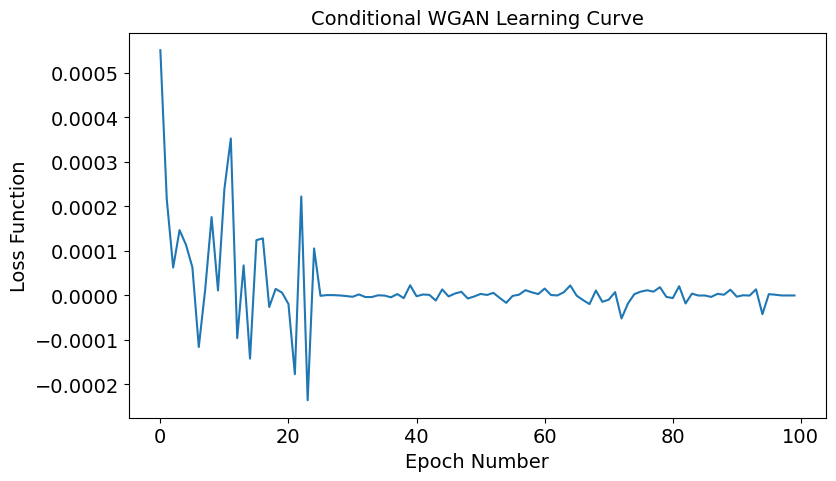

In [31]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
#plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [32]:
X_train_new = qt.inverse_transform(X_train)
X_test_new = qt.inverse_transform(X_test)

In [33]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

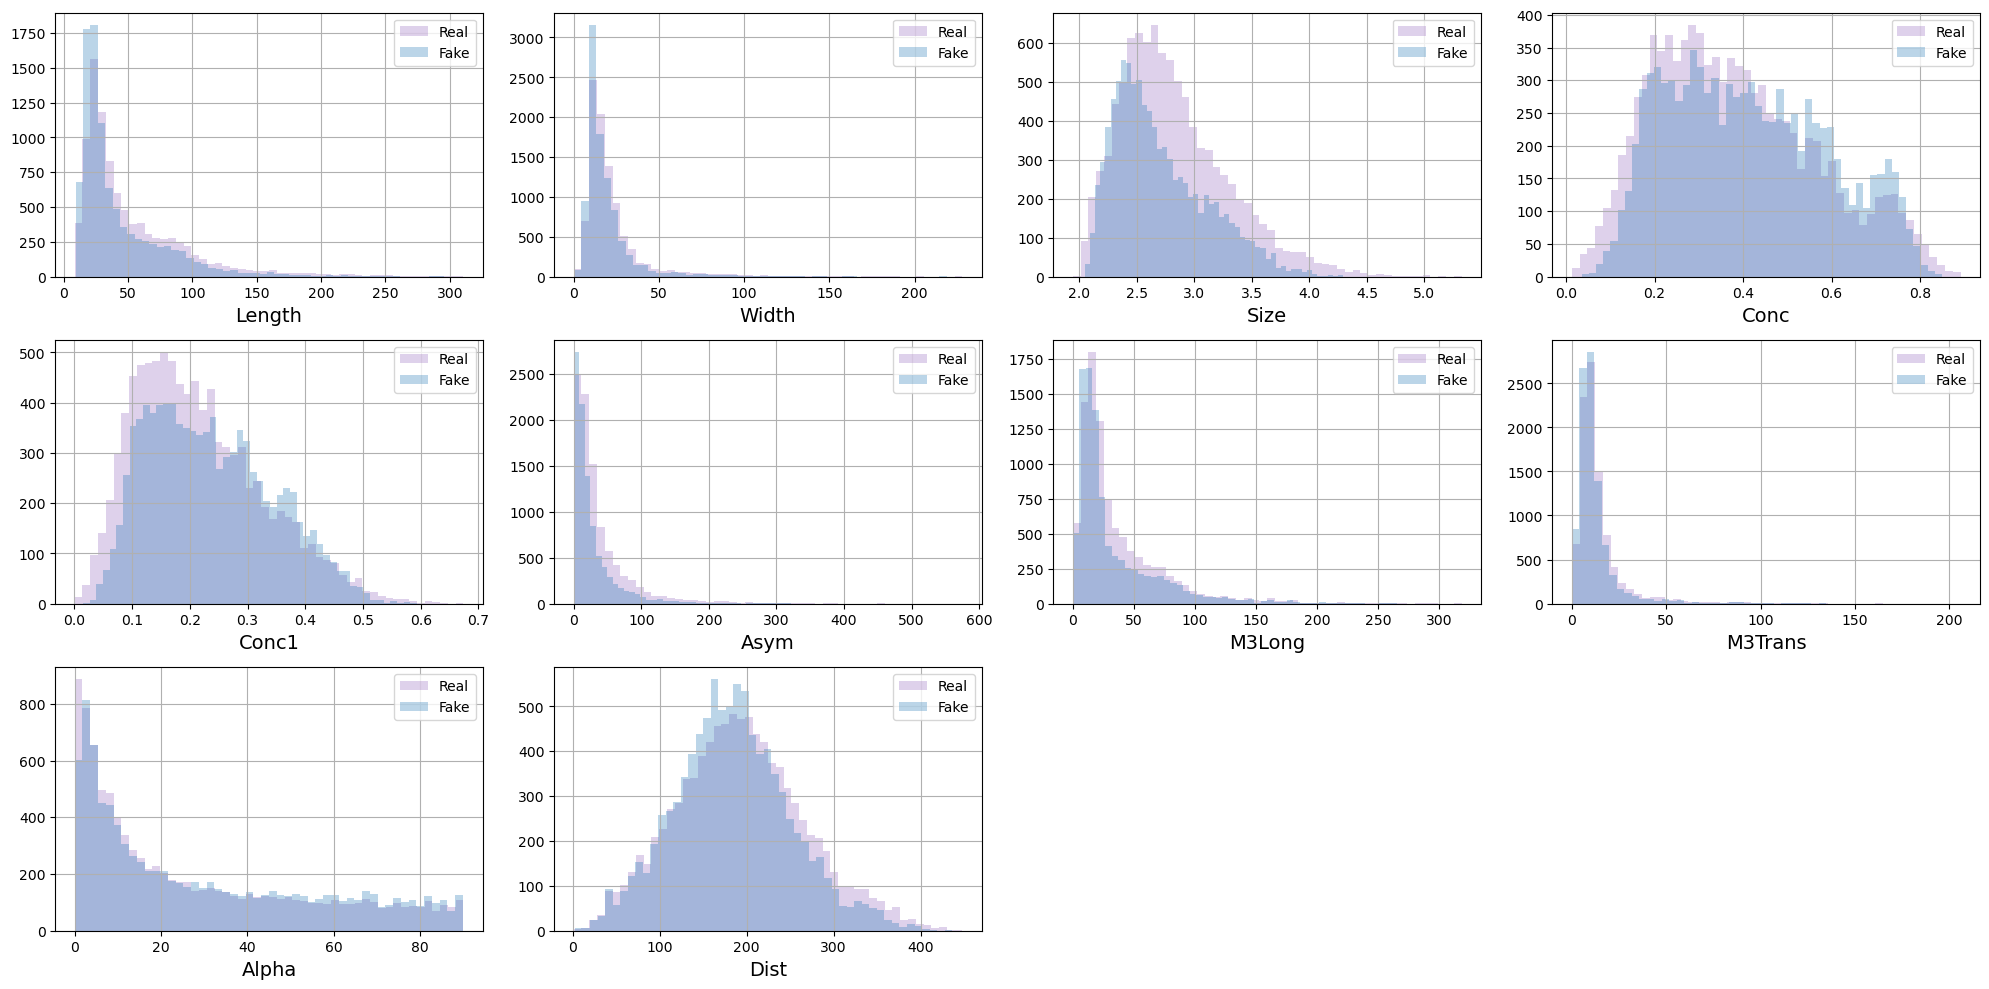

In [34]:
plot_hists(X_train_new, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [35]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

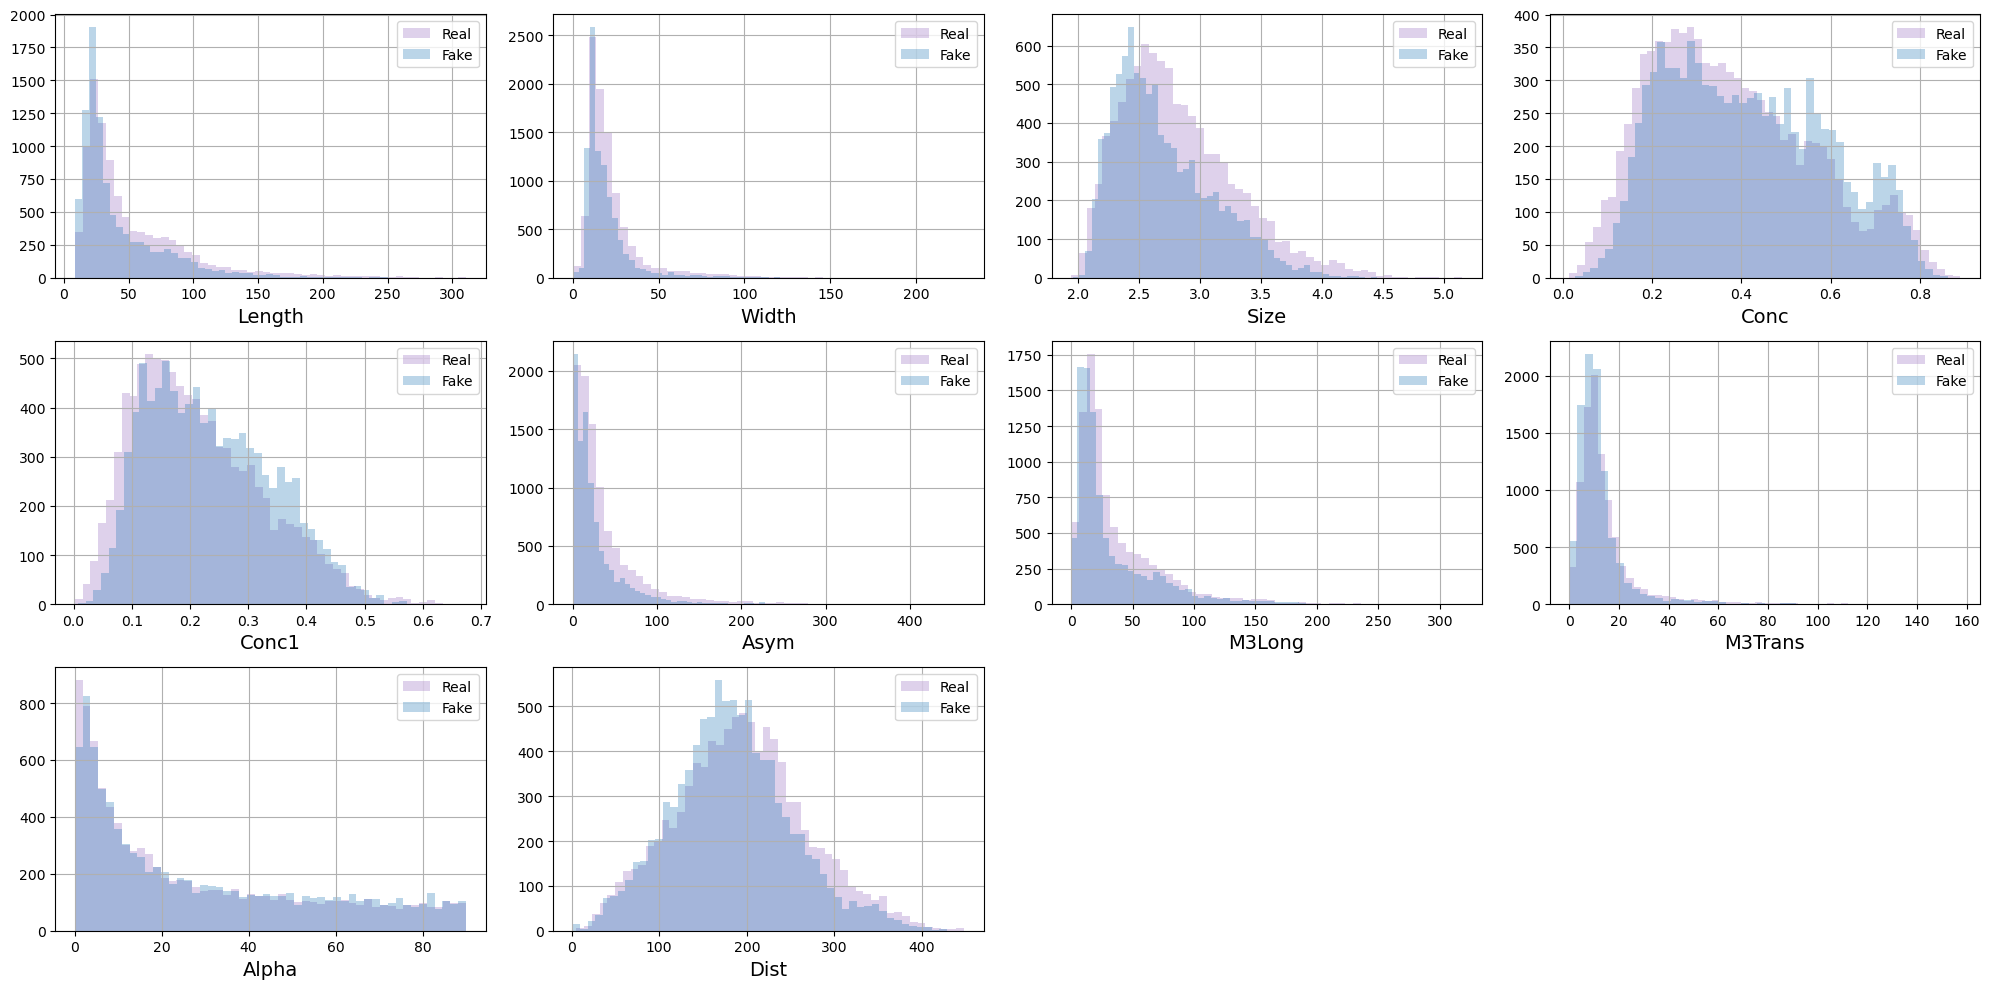

In [36]:
plot_hists(X_test_new, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [37]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_new), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_new), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_new))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_new))

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [39]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7688310495012721


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


По итогу мы получили генератор, который хорошо создает фейковые обьекты, но не идеально тк GradientBoostingClassifier смог какие-то из них идентифицировать как фейки, откуда и результат аук рок 0.768.
Чем ближе ROC AUC к 0.5, тем лучше, это значит, что фейки смешались с реальными обьектами, их невохможно отличить друг от друга

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [40]:
from diffusers import DDPMScheduler

In [41]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount

## Добавим sсheduler, он пригодится вам при обучении модели

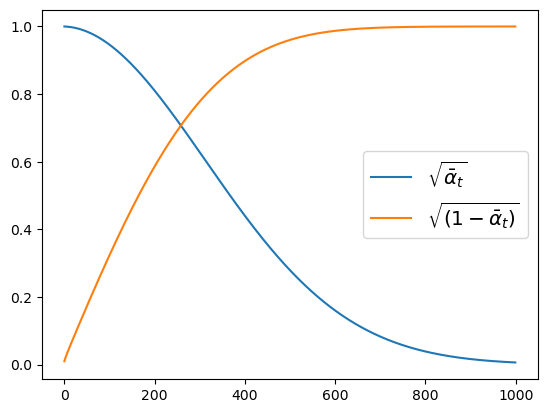

In [42]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [43]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.relu = nn.ReLU()

        self.batch_norm1 = torch.nn.BatchNorm1d(100)
        self.batch_norm2 = torch.nn.BatchNorm1d(100)

        self.linear1 = nn.Linear(n_inputs, 100)
        self.linear2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, n_outputs)

        pass
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1).to(torch.float32)
        zy = self.linear1(zy)
        zy = self.batch_norm1(zy)
        zy = self.relu(zy)
        zy = self.linear2(zy)
        zy = self.batch_norm2(zy)
        zy = self.relu(zy)
        return self.output(zy)

Качество будем мерять MSELoss так как сравнение идет картинок между собой

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [44]:
def generate_with_diffusion(model, y, latent_dim):#, sheduler):
    ### YOUR CODE IS HERE ######
    z = torch.normal(mean=0, std=1, size=(len(y), latent_dim))
    X_fake = model(z, torch.tensor(y)).detach().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [45]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss_gen = nn.MSELoss()

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # c scheduler

                # без scheduler
                self.opt_gen.zero_grad()

                noise_amount = torch.rand(len(real_batch))
                noisy_x = corrupt(real_batch, noise_amount)

                fake_batch = self.model(noisy_x, cond_batch)

                loss = self.loss_gen(fake_batch, real_batch)
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.detach().numpy()

            # calculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            noise_amount = torch.rand(len(X_real))
            noisy_x = corrupt(X_real, noise_amount)
            X_fake = self.model(noisy_x, y_cond)
            other_agent_score(X_real[:1000].detach().numpy(), 
                              y_cond[:1000],
                              X_fake[:1000].detach().numpy(), 
                              y_cond[:1000]
            )
            ### THE END OF YOUR CODE ###
            print('epoch', epoch)

        # Turn off training
        self.model.train(False)

In [46]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.458
Boosting score: 0.756
epoch 0
Linear regression score: 0.476
Boosting score: 0.654
epoch 1
Linear regression score: 0.496
Boosting score: 0.61
epoch 2
Linear regression score: 0.47
Boosting score: 0.608
epoch 3
Linear regression score: 0.432
Boosting score: 0.582
epoch 4
Linear regression score: 0.466
Boosting score: 0.614
epoch 5
Linear regression score: 0.452
Boosting score: 0.596
epoch 6
Linear regression score: 0.452
Boosting score: 0.612
epoch 7
Linear regression score: 0.482
Boosting score: 0.566
epoch 8
Linear regression score: 0.472
Boosting score: 0.572
epoch 9
Linear regression score: 0.462
Boosting score: 0.602
epoch 10
Linear regression score: 0.472
Boosting score: 0.628
epoch 11
Linear regression score: 0.474
Boosting score: 0.598
epoch 12
Linear regression score: 0.466
Boosting score: 0.612
epoch 13
Linear regression score: 0.45
Boosting score: 0.602
epoch 14
Linear regression score: 0.496
Boosting score: 0.574
epoch 15
Linear regression sco

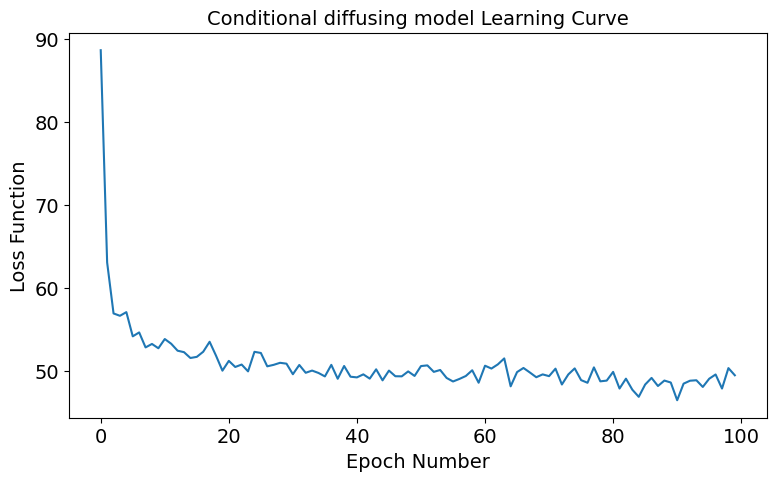

In [47]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
#plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [48]:
X_diff_train = generate(diffusionFitter.model, y_train, latent_dim)
X_diff_train = qt.inverse_transform(X_diff_train)

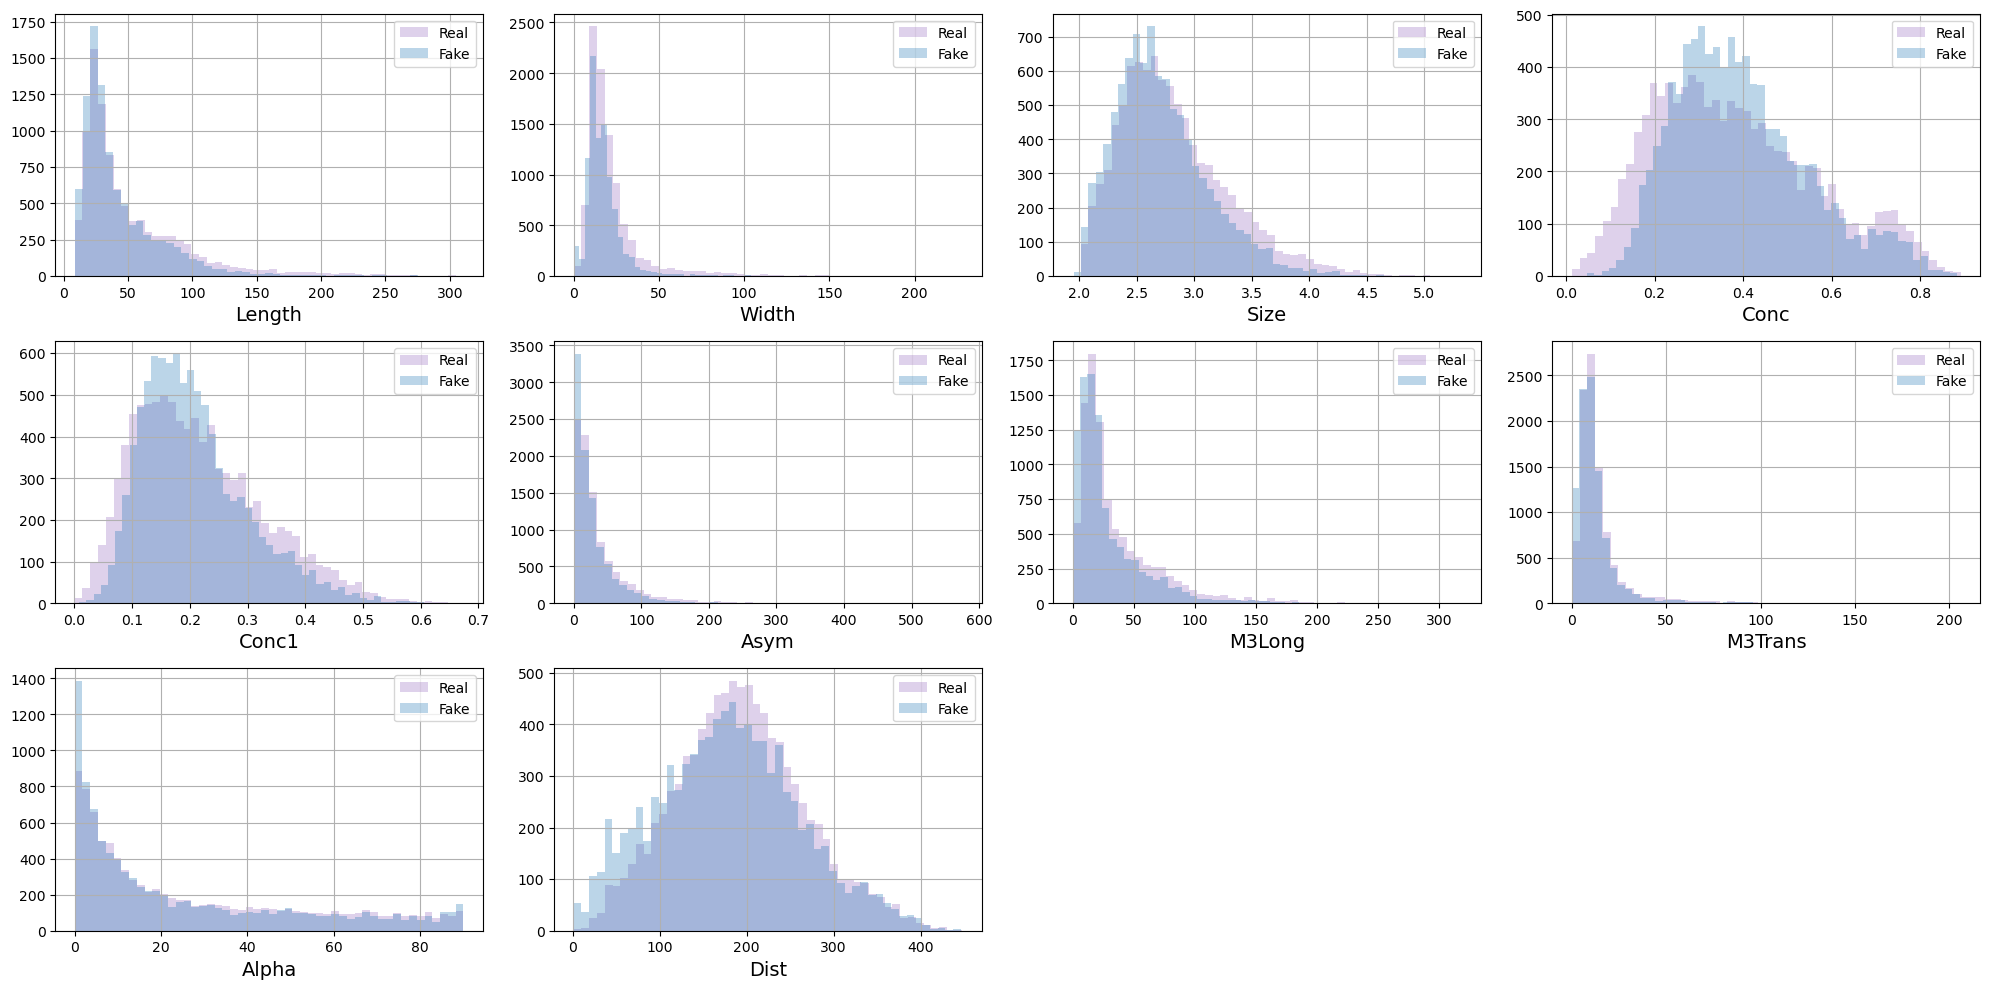

In [49]:
plot_hists(X_train_new, X_diff_train, names, label1="Real", label2="Fake", bins=50)

In [50]:
X_diff_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim)
X_diff_test = qt.inverse_transform(X_diff_test)

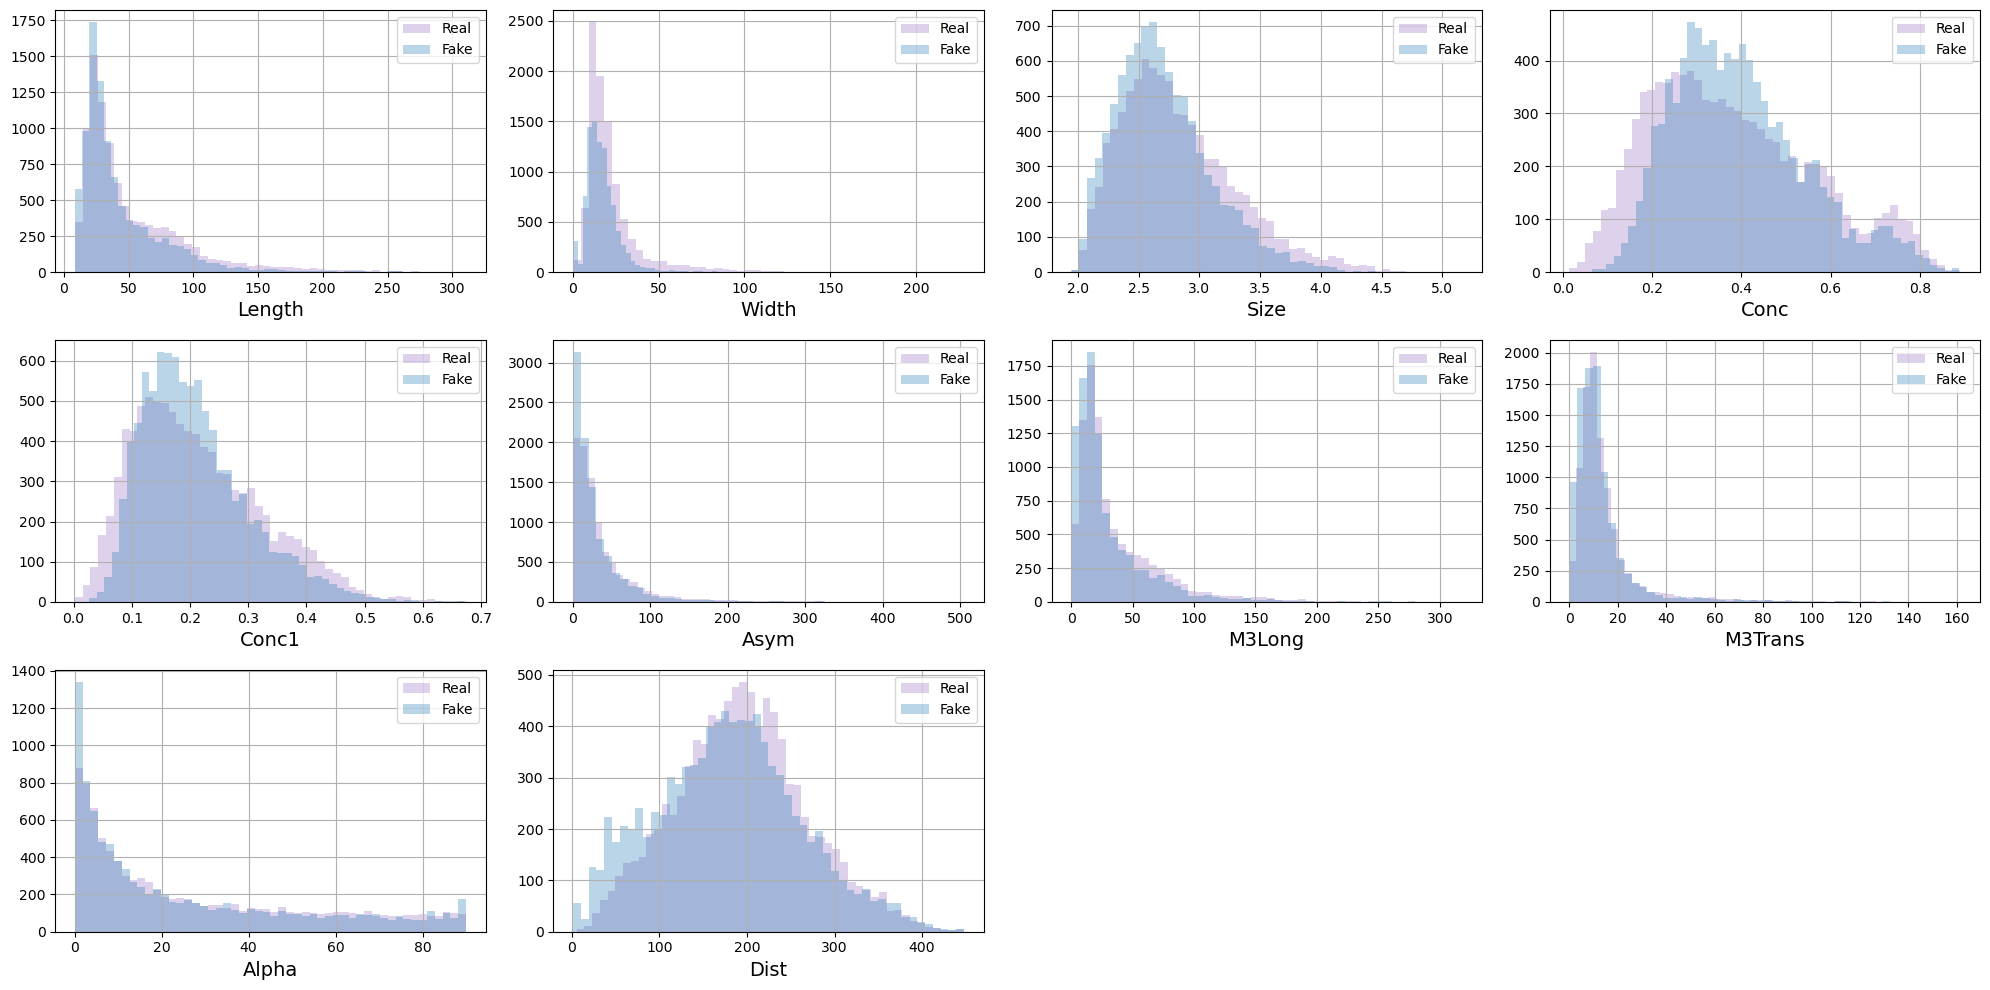

In [51]:
plot_hists(X_test_new, X_diff_test, names, label1="Real", label2="Fake", bins=50)

In [52]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_diff_train, X_train_new), axis=0)
XX_test = np.concatenate((X_diff_test, X_test_new), axis=0)

yy_train = np.array([0] * len(X_diff_train) + [1] * len(X_train_new))
yy_test = np.array([0] * len(X_diff_test) + [1] * len(X_test_new))

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [54]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9286352790410447


In [55]:
print("accuracy = ", clf.score(XX_test, yy_test))

accuracy =  0.8546267087276551


По итогу диффузионная модель показала себя сильно хуже, чем GAN. Она практически не научилась хорошо генерировать картинки настолько, чтобы хорошо обманывать GradientBoostingClassifier. 

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

хорошая домашка, спасибо)